In [17]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

In [18]:
df = ml_model.canonical_df
# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)
df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop(['item_type'], axis = 1)
print(df.shape)

(5762, 1714)


In [19]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = title
    #parse_title.create_one_hot_row_adj(text, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [20]:
df = pd.concat([df, df_adj], axis = 1)
df.shape

(5762, 1877)

In [21]:
features = df.columns.drop(['rent_per_week', 'title', 'cost', 'is_train', 'description']) # just column names
train, test = df[df['is_train']==True], df[df['is_train']==False]
train.columns

Index(['title', 'cost', 'rent_per_week', 'description', 'is_train',
       '  Dolce & Gabbana', ' Adrianna Papell', ' Alexia Admor',
       ' Amanda Uprichard', ' Basix II',
       ...
       'gala', 'runway', 'ball', 'costume', 'iconic', 'cavier', 'peacock',
       'florence', 'mermaid', 'jersey'],
      dtype='object', length=1877)

In [22]:
y = train['rent_per_week']
#print("Shape of test df: {}".format(test.shape))
#print('Number of observations in the test data: {}'.format(df_full_test.shape))
from sklearn import svm, linear_model

#clf = svm.SVR() # didn't work. Predicted 43 for everything
reg = RandomForestRegressor(n_jobs=2, n_estimators=15)
reg.fit(train[features], train['rent_per_week'])
#rfr_predicted = clf.predict(test[features])
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu

#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu

reg.fit(train[features], train['rent_per_week'])
rfr_predicted = clf.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted


['/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles/rfr_v0.1_no_adj.pkl']

In [23]:
print(len(clf.feature_importances_))
print(len(train.columns))

1872
1877


In [24]:
reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr but much faster to compute
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu

#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu



In [25]:
features.values
#coef_df = pd.DataFrame(reg.coef_, columns = features.values)


AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [26]:
reg.fit(train[features], train['rent_per_week'])
r2 = reg.score(train[features], train['rent_per_week'])
rfr_predicted = reg.predict(test[features])
r2

0.67442752320665256

Coefficients:  [  5.66265398e+10]
Mean squared error: 13853567647447578003449577472.00
Variance score: 0.00
Length of df_full_test: 1446


/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

NameError: name 'df_error' is not defined

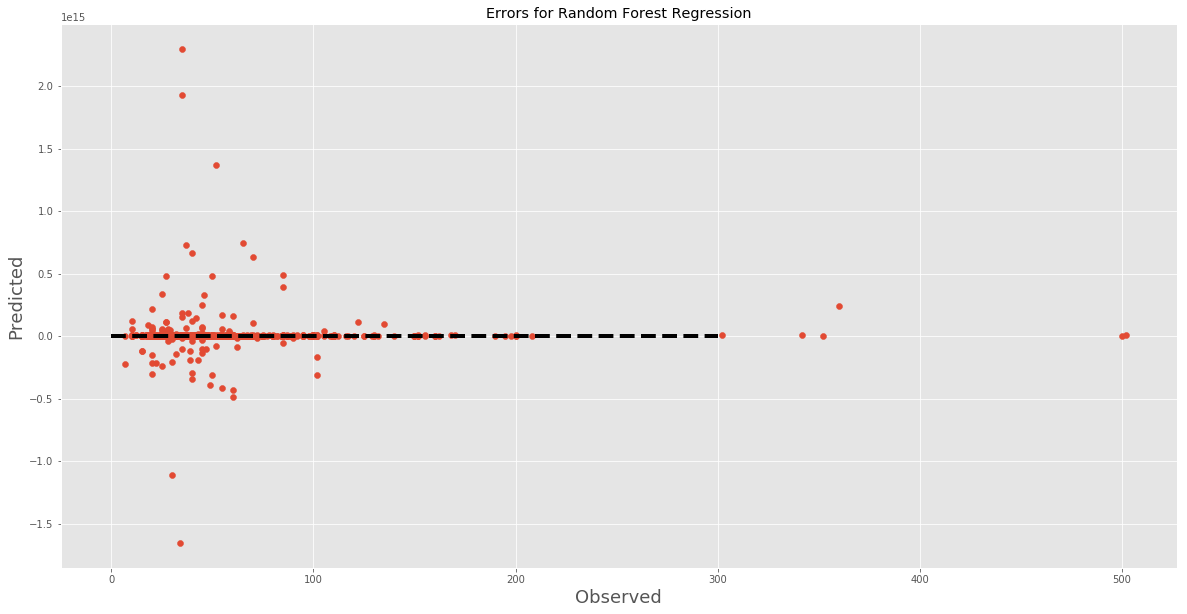

In [27]:
from sklearn import linear_model

# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: ', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
#stopping_value = np.minimum(test['rent_per_week'].max, np.maximum(rfr_predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
#ax.plot(x, reg.predict(x), 'k--', color='blue', linewidth=3)

#ax.text(0, 70, 'Coefficients: {}'.format(reg.coef_), style='italic', fontsize=16,
       # bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(0,500, "Mean squared error: %.2f"
      #% np.mean((reg.predict(x) - y) ** 2), style='italic', fontsize=16,
      #  bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
#ax.text(20, 100, 'Variance score: %.2f' % reg.score(x, y), style='italic', fontsize=16,
     #   bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = rfr_predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
print("Length of df_full_test: {}".format(len(df_full_test)))
df_full_test['error'] = df_full_test['error'].abs()
#df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
#reg.score(x, y)
print("Length of df_error: {}".format(len(df_error)))

In [ ]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_low_errors)/len(d_errors))
print(len(num_high_errors))
d_errors = df_full_test.sort_values('error', ascending=True)
d_errors

In [ ]:
df_error[df_error['brand']=='Yves Saint Laurent']

In [ ]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

In [ ]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()